# Data loading & EDA (Exploratory Data Analysis)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
from tabulate import tabulate
import seaborn as sns
from scipy.stats import pearsonr
import timeit
import time
import os

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,mean_squared_error, confusion_matrix, recall_score, precision_score,f1_score, roc_auc_score, classification_report
import xgboost as xgb

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
from tensorflow.keras import regularizers
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [3]:
data = pd.read_csv("/content/drive/MyDrive/TFM/cell2celltrain.csv")
data.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

In [5]:
#Check columns with missing values
na_cols = data.columns[data.isnull().sum() != 0]
data[na_cols].isnull().sum()

MonthlyRevenue           156
MonthlyMinutes           156
TotalRecurringCharge     156
DirectorAssistedCalls    156
OverageMinutes           156
RoamingCalls             156
PercChangeMinutes        367
PercChangeRevenues       367
ServiceArea               24
Handsets                   1
HandsetModels              1
CurrentEquipmentDays       1
AgeHH1                   909
AgeHH2                   909
dtype: int64

In [6]:
#Removing rows with null values
data = data.dropna()

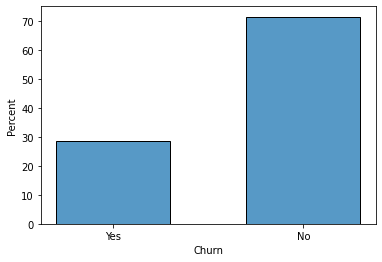

In [7]:
#Histogram of initial Churn feature
sns.histplot(data.Churn, stat= "percent", shrink=.6)

In [8]:
#Removing non useful information
data.drop(columns = ['CustomerID', 'ServiceArea','PrizmCode'], inplace = True)

#Split numerical and categorical columns
num_cols = data.columns[data.dtypes != 'object']
cat_cols = data.columns[data.dtypes == 'object']

## Numerical Features

In [9]:
#Description data raw
data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyRevenue,49752.0,58.717374,44.317244,-6.17,33.61,48.38,70.91,1223.38
MonthlyMinutes,49752.0,525.021466,528.510155,0.00,158.00,366.00,722.00,7359.00
TotalRecurringCharge,49752.0,46.834961,23.759492,-6.00,30.00,45.00,60.00,400.00
DirectorAssistedCalls,49752.0,0.891841,2.224725,0.00,0.00,0.25,0.99,159.39
OverageMinutes,49752.0,39.754040,96.091606,0.00,0.00,3.00,40.00,4321.00
RoamingCalls,49752.0,1.226327,9.848360,0.00,0.00,0.00,0.30,1112.40
PercChangeMinutes,49752.0,-11.656175,255.858193,-3875.00,-83.00,-5.00,65.00,5192.00
PercChangeRevenues,49752.0,-1.175937,39.392124,-1107.70,-7.00,-0.30,1.60,2483.50
DroppedCalls,49752.0,6.010556,9.036653,0.00,0.70,3.00,7.70,221.70
BlockedCalls,49752.0,4.077814,10.836468,0.00,0.00,1.00,3.70,324.70


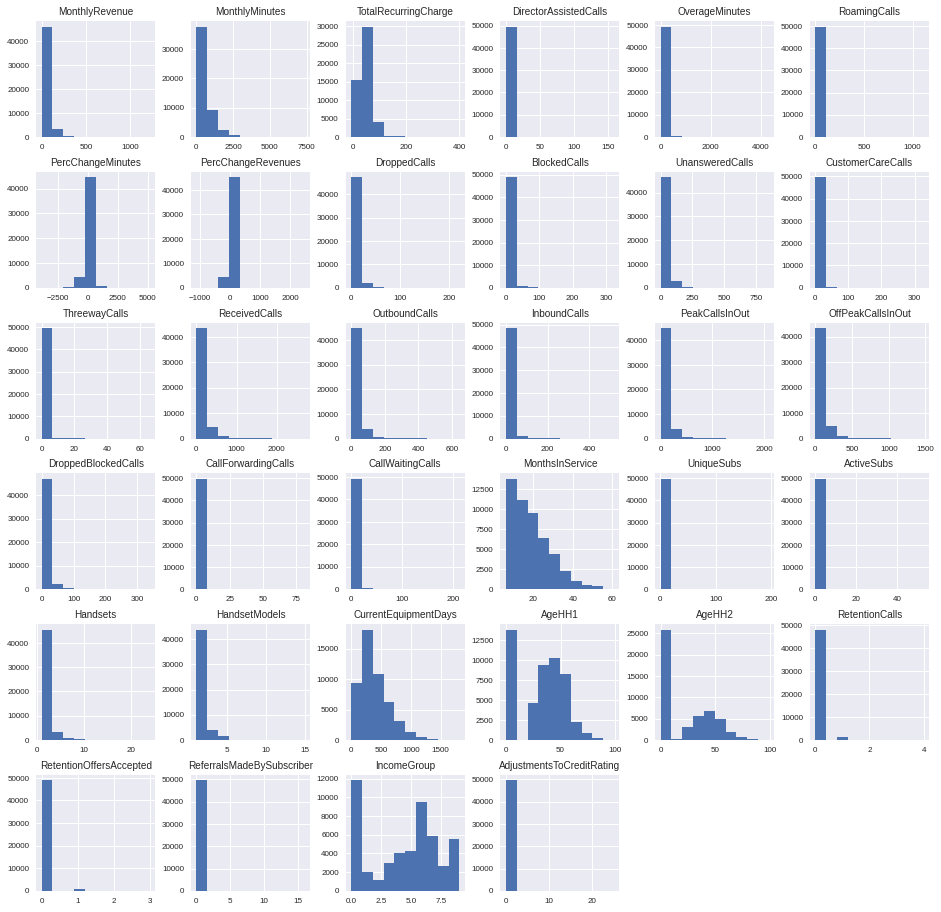

In [10]:
#Graphical visualization raw data
plt.style.use("seaborn")
params = {'axes.titlesize':'10','xtick.labelsize':'8', 'ytick.labelsize':'8','figure.dpi':72}
matplotlib.rcParams.update(params)
data[num_cols].hist(figsize = (16, 16));

## Categorical Features

In [11]:
#Feature Churn converted to numerical
data['Churn'] = data['Churn'].replace({'Yes':1, 'No': 0})

#Calculation of diferent values for each categorical feature
feat = pd.DataFrame([[c, data[c].nunique()] for c in data[cat_cols].columns], columns = ['Feature', 'Number']).set_index('Feature')

In [12]:
#Split between binary columns and columns with more than 2 unique values
bin_cols = feat[feat.Number == 2].index.tolist()
non_bin_cols = feat[feat.Number > 2].index.tolist()

In [13]:
#Convert to numerical binary columns
for c in bin_cols: 
    data[c] = LabelBinarizer().fit_transform(data[c])

In [14]:
#Convert to numerical non-binary columns
#CreditRating
data.CreditRating.value_counts()

2-High       18692
1-Highest     8368
3-Good        8221
5-Low         6320
4-Medium      5227
7-Lowest      2049
6-VeryLow      875
Name: CreditRating, dtype: int64

In [15]:
data['CreditRating'] = [x[0] for x in data['CreditRating']]
data['CreditRating'] = LabelEncoder().fit_transform(data['CreditRating'])
non_bin_cols.remove('CreditRating')

In [16]:
#HandsetPrice
data.HandsetPrice.value_counts()

Unknown    28263
30          7147
150         4024
130         2043
80          1901
10          1869
60          1730
200         1227
100         1209
40           240
400           45
250           20
300           12
180            9
500            7
240            6
Name: HandsetPrice, dtype: int64

In [17]:
Handset_list = data['HandsetPrice'].tolist()
Handset_list_cat = []

for x in Handset_list:
    if x == 'Unknown':
        Handset_list_cat.append(x)
    elif int(x)<80:
        Handset_list_cat.append('<80')
    elif int(x)<150:
        Handset_list_cat.append('80 to 150')
    elif int(x)>=150:
        Handset_list_cat.append('>150')
        
data['HandsetPrice_cat'] = Handset_list_cat
data.HandsetPrice_cat.value_counts()

Unknown      28263
<80          10986
>150          5350
80 to 150     5153
Name: HandsetPrice_cat, dtype: int64

In [18]:
data.drop(columns =['HandsetPrice'], inplace = True)
non_bin_cols.remove('HandsetPrice')
non_bin_cols.append('HandsetPrice_cat')

In [19]:
#Occupation (no changes)
data.Occupation.value_counts()

Other           36453
Professional     8681
Crafts           1507
Clerical          979
Self              872
Retired           726
Student           377
Homemaker         157
Name: Occupation, dtype: int64

In [20]:
#Transform remaining non binary columns 
data = pd.get_dummies(data, columns = non_bin_cols, dtype=float)

In [21]:
#Description data cleansed
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Churn,49752.0,0.286320,0.452045,0.00,0.00,0.00,1.00,1.00
MonthlyRevenue,49752.0,58.717374,44.317244,-6.17,33.61,48.38,70.91,1223.38
MonthlyMinutes,49752.0,525.021466,528.510155,0.00,158.00,366.00,722.00,7359.00
TotalRecurringCharge,49752.0,46.834961,23.759492,-6.00,30.00,45.00,60.00,400.00
DirectorAssistedCalls,49752.0,0.891841,2.224725,0.00,0.00,0.25,0.99,159.39
...,...,...,...,...,...,...,...,...
MaritalStatus_Yes,49752.0,0.371965,0.483334,0.00,0.00,0.00,1.00,1.00
HandsetPrice_cat_80 to 150,49752.0,0.103574,0.304710,0.00,0.00,0.00,0.00,1.00
HandsetPrice_cat_<80,49752.0,0.220815,0.414800,0.00,0.00,0.00,0.00,1.00
HandsetPrice_cat_>150,49752.0,0.107533,0.309793,0.00,0.00,0.00,0.00,1.00


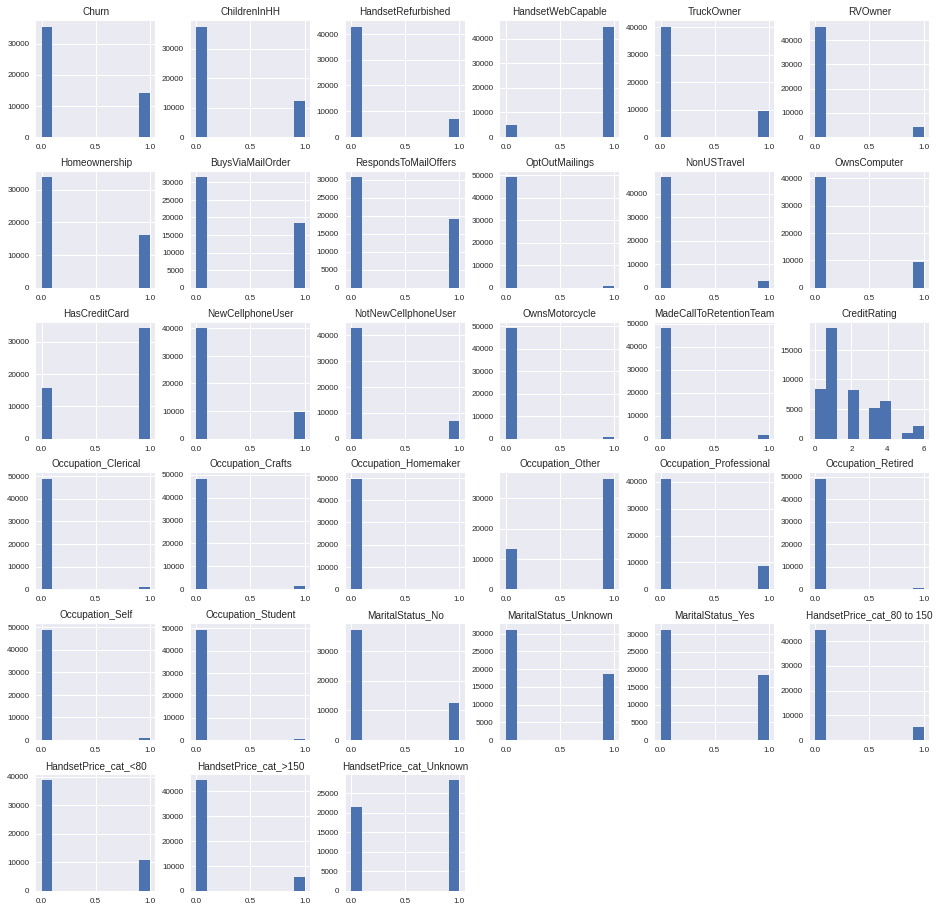

In [22]:
#Visualizing new numerical columns created
data_new = data.copy(deep=True)
num_cols.tolist()
data_new = data_new.drop(columns = num_cols)

data_new.hist(figsize = (16, 16));

# Data Preparation

## Balancing Data

In [23]:
#Scale features
y = data.Churn
X = data.copy(deep=True)
X = X.drop(columns = ['Churn'])
StdS = StandardScaler()
Xs = StdS.fit_transform(X)

labels = data.columns.to_list()
labels.remove('Churn')

### Obtaining scores with full data and XGBoost classifier

In [24]:
#Normalizing data
StdS = StandardScaler()
Xs = StdS.fit_transform(X)

# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape
feat_full = X_train.shape[1]

In [25]:
# Create a XGBoost classifier
clf = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                       max_depth = 5, alpha = 10, n_estimators = 5000)
clf.fit(X_train,np.ravel(y_train,order='C'))
y_pred = clf.predict(X_test)

In [26]:
# Obtaining metrics data full
acc_full = accuracy_score(y_test, y_pred)
f1_full = f1_score(y_test, y_pred)
precision_full = precision_score(y_test, y_pred)
recall_full = recall_score(y_test, y_pred)
auc_full = roc_auc_score(y_test, y_pred)
print('Accuracy with full data: {0:.4f}'.format(acc_full*100),'%')
print('F1_score with full data: {0:.4f}'.format(f1_full*100),'%')
print('Precision with full data: {0:.4f}'.format(precision_full*100),'%')
print('Recall with full data: {0:.4f}'.format(recall_full*100),'%')
print('AUC with full data: {0:.4f}'.format(auc_full*100),'%')

Accuracy with full data: 70.8763 %
F1_score with full data: 32.1523 %
Precision with full data: 49.0010 %
Recall with full data: 23.9257 %
AUC with full data: 56.9162 %


### Applying SMOTE&NCR and obtaining scores with same model

In [27]:
#Apply SMOTE and NCR to our imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule

sm = SMOTE(random_state=42)
ncr = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
X_sm, y_sm = sm.fit_resample(Xs, y)
X_res, y_res = ncr.fit_resample(X_sm, y_sm)

In [28]:
from collections import Counter

counter_original = Counter(y)
counter_smote = Counter(y_sm)
counter_ncr = Counter(y_res)

results2 = [['Data', 'Churn = No', 'Churn = Yes'], 
         ['Original', counter_original[0], counter_original[1]], 
         ['SMOTE', counter_smote[0], counter_smote[1]], 
         ['NCR', counter_ncr[0], counter_ncr[1]]]

print(tabulate(results2, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤══════════════╤═══════════════╕
│ Data     │   Churn = No │   Churn = Yes │
╞══════════╪══════════════╪═══════════════╡
│ Original │        35507 │         14245 │
├──────────┼──────────────┼───────────────┤
│ SMOTE    │        35507 │         35507 │
├──────────┼──────────────┼───────────────┤
│ NCR      │        35507 │         32402 │
╘══════════╧══════════════╧═══════════════╛


In [29]:
X_inversed = StdS.inverse_transform(X_res)
data_balanced = pd.DataFrame(X_inversed, columns = labels)
data_balanced['Churn'] = y_res
data_balanced.head()

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,...,Occupation_Self,Occupation_Student,MaritalStatus_No,MaritalStatus_Unknown,MaritalStatus_Yes,HandsetPrice_cat_80 to 150,HandsetPrice_cat_<80,HandsetPrice_cat_>150,HandsetPrice_cat_Unknown,Churn
0,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
2,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
3,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1


In [30]:
# Calculating scores after balancing data
y = data_balanced.Churn
X = data_balanced.copy()
X = X.drop(columns = ['Churn'])

StdS = StandardScaler()
Xs = StdS.fit_transform(X)

# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape
feat_bal = X_train.shape[1]

In [31]:
# Create a XGBoost classifier
clf = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                       max_depth = 5, alpha = 10, n_estimators = 5000)
clf.fit(X_train,np.ravel(y_train,order='C'))
y_pred = clf.predict(X_test)

In [32]:
# Obtaining metrics
acc_bal = accuracy_score(y_test, y_pred)
f1_bal = f1_score(y_test, y_pred)
precision_bal = precision_score(y_test, y_pred)
recall_bal = recall_score(y_test, y_pred)
auc_bal = roc_auc_score(y_test, y_pred)
print('Accuracy with balanced data: {0:.4f}'.format(acc_bal*100),'%')
print('F1_score with balanced data: {0:.4f}'.format(f1_bal*100),'%')
print('Precision with balanced data: {0:.4f}'.format(precision_bal*100),'%')
print('Recall with balanced data: {0:.4f}'.format(recall_bal*100),'%')
print('AUC with balanced data: {0:.4f}'.format(auc_bal*100),'%')

Accuracy with balanced data: 82.3296 %
F1_score with balanced data: 79.5012 %
Precision with balanced data: 89.1116 %
Recall with balanced data: 71.7619 %
AUC with balanced data: 81.8744 %


## Feature Selection

### Lasso regression

In [33]:
# Splitting and normalising to apply Lasso Regression
y = data_balanced.Churn
X = data_balanced.copy()
X = X.drop(columns = ['Churn'])

StdS = StandardScaler()
Xs = StdS.fit_transform(X)

# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape
feat_bal = X_train.shape[1]

In [34]:
#Appliying Lasso regression
selector = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
selector.fit(X_train, np.ravel(y_train,order='C'))
selector.get_support()
X_train = pd.DataFrame(X_train)

selected_feat = X_train.columns[(selector.get_support())]
print('Total features: {}'.format((X_train.shape[1])))
print('Selected features: {}'.format(len(selected_feat)))
print('Features with coefficients shrank to zero: {}'.format(np.sum(selector.estimator_.coef_ == 0)))

Total features: 66
Selected features: 64
Features with coefficients shrank to zero: 2


In [35]:
#List of removed features
removed_feats = X_train.columns[(selector.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

#New data splitted without removed features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape
feat_lasso = X_train_selected.shape[1]

In [36]:
#New dataset without features removed due to lasso
X_lasso = X.drop(X.columns[(selector.estimator_.coef_ == 0).ravel().tolist()], axis='columns')
data_lasso = X_lasso.copy()
data_lasso['Churn'] = y

In [37]:
# Splitting and normalising to find scores
y = data_lasso.Churn
X = data_lasso.copy()
X = X.drop(columns = ['Churn'])

StdS = StandardScaler()
Xs = StdS.fit_transform(X)

# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape
feat_lasso = X_train.shape[1]

In [38]:
# Create a XGBoost classifier
clf = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                       max_depth = 5, alpha = 10, n_estimators = 5000)
clf.fit(X_train_selected,np.ravel(y_train,order='C'))
y_pred_selected = clf.predict(X_test_selected)

In [39]:
# Obtaining metrics
acc_lasso = accuracy_score(y_test, y_pred_selected)
f1_lasso = f1_score(y_test, y_pred_selected)
precision_lasso = precision_score(y_test, y_pred_selected)
recall_lasso = recall_score(y_test, y_pred_selected)
auc_lasso = roc_auc_score(y_test, y_pred_selected)
print('Accuracy with full data: {0:.4f}'.format(acc_lasso*100),'%')
print('F1_score with full data: {0:.4f}'.format(f1_lasso*100),'%')
print('Precision with full data: {0:.4f}'.format(precision_lasso*100),'%')
print('Recall with full data: {0:.4f}'.format(recall_lasso*100),'%')
print('AUC with full data: {0:.4f}'.format(auc_lasso*100),'%')

Accuracy with full data: 82.3296 %
F1_score with full data: 79.5105 %
Precision with full data: 89.0717 %
Recall with full data: 71.8030 %
AUC with full data: 81.8762 %


### Variance Threshold

In [40]:
#Reducing features considering VarianceThreshold with variance > 0.5

# Create VarianceThreshold object
def variance_threshold_selector(data, threshold):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

features = variance_threshold_selector(data_lasso, threshold=0.5).columns
features = features.insert(-1,'Churn')
data_reduced = data_lasso[features]
data_reduced.shape

(67909, 30)

In [41]:
data_reduced.head()

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,...,MonthsInService,UniqueSubs,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,IncomeGroup,Churn,CreditRating
0,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,...,61.0,2.0,2.0,2.0,361.0,62.0,0.0,4.0,1,0.0
1,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,...,58.0,1.0,2.0,1.0,1504.0,40.0,42.0,5.0,1,3.0
2,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,...,60.0,1.0,1.0,1.0,1812.0,26.0,26.0,6.0,0,2.0
3,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,...,59.0,2.0,9.0,4.0,458.0,30.0,0.0,6.0,0,3.0
4,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,...,53.0,2.0,4.0,3.0,852.0,46.0,54.0,9.0,1,0.0


In [42]:
y = data_reduced.Churn
X = data_reduced.copy()
X = X.drop(columns = ['Churn'])

StdS = StandardScaler()
Xs = StdS.fit_transform(X)

# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape
feat_vt = X_train.shape[1]

In [43]:
# Create a XGBoost classifier
clf = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                       max_depth = 5, alpha = 10, n_estimators = 5000)
clf.fit(X_train,np.ravel(y_train,order='C'))
y_pred_reduced = clf.predict(X_test)

In [44]:
# Obtaining metrics
acc_vt = accuracy_score(y_test, y_pred_reduced)
f1_vt = f1_score(y_test, y_pred_reduced)
precision_vt = precision_score(y_test, y_pred_reduced)
recall_vt = recall_score(y_test, y_pred_reduced)
auc_vt = roc_auc_score(y_test, y_pred_reduced)
print('Accuracy with full data: {0:.4f}'.format(acc_vt*100),'%')
print('F1_score with full data: {0:.4f}'.format(f1_vt*100),'%')
print('Precision with full data: {0:.4f}'.format(precision_vt*100),'%')
print('Recall with full data: {0:.4f}'.format(recall_vt*100),'%')
print('AUC with full data: {0:.4f}'.format(auc_vt*100),'%')

Accuracy with full data: 82.3246 %
F1_score with full data: 79.4217 %
Precision with full data: 89.4222 %
Recall with full data: 71.4330 %
AUC with full data: 81.8555 %


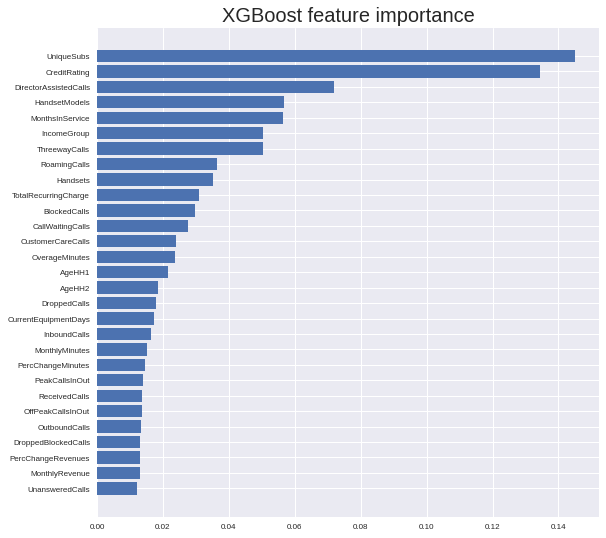

In [45]:
#Printing feature importance
feature_names = list(X.columns.values)
Feat_imp = pd.DataFrame(clf.feature_importances_, columns=["Feat_value"])
Feat_imp['Feat_name'] = feature_names
Feat_imp_ordered = Feat_imp.sort_values('Feat_value')

fig, ax = plt.subplots(figsize=(9, 9))
plt.style.use("seaborn")
plt.barh(Feat_imp_ordered['Feat_name'],Feat_imp_ordered['Feat_value'])
plt.title("XGBoost feature importance", size = 20);


In [46]:
from tabulate import tabulate

results = [['Data', 'Features', 'Accuracy(%)', 'F1_score(%)', 'Precision(%)', 'Recall(%)', 'AUC(%)'],
           ['Full data', feat_full, round(acc_full*100,4), round(f1_full*100,4), round(precision_full*100,4), round(recall_full*100,4), round(auc_full*100,4)],
           ['SMOTE&NCR', feat_bal, round(acc_bal*100,4), round(f1_bal*100,4), round(precision_bal*100,4), round(recall_bal*100,4), round(auc_bal*100,4)],
           ['Lasso Selection', feat_lasso, round(acc_lasso*100,4), round(f1_lasso*100,4), round(precision_lasso*100,4), round(recall_lasso*100,4), round(auc_lasso*100,4)],
           ['Variance Threshold', feat_vt, round(acc_vt*100,4), round(f1_vt*100,4), round(precision_vt*100,4), round(recall_vt*100,4), round(auc_vt*100,4)]]

print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════╤════════════╤═══════════════╤═══════════════╤════════════════╤═════════════╤══════════╕
│ Data               │   Features │   Accuracy(%) │   F1_score(%) │   Precision(%) │   Recall(%) │   AUC(%) │
╞════════════════════╪════════════╪═══════════════╪═══════════════╪════════════════╪═════════════╪══════════╡
│ Full data          │         66 │       70.8763 │       32.1523 │        49.001  │     23.9257 │  56.9162 │
├────────────────────┼────────────┼───────────────┼───────────────┼────────────────┼─────────────┼──────────┤
│ SMOTE&NCR          │         66 │       82.3296 │       79.5012 │        89.1116 │     71.7619 │  81.8744 │
├────────────────────┼────────────┼───────────────┼───────────────┼────────────────┼─────────────┼──────────┤
│ Lasso Selection    │         64 │       82.3296 │       79.5105 │        89.0717 │     71.803  │  81.8762 │
├────────────────────┼────────────┼───────────────┼───────────────┼────────────────┼─────────────┼──────────┤
│ Variance

## Correlation Analysis

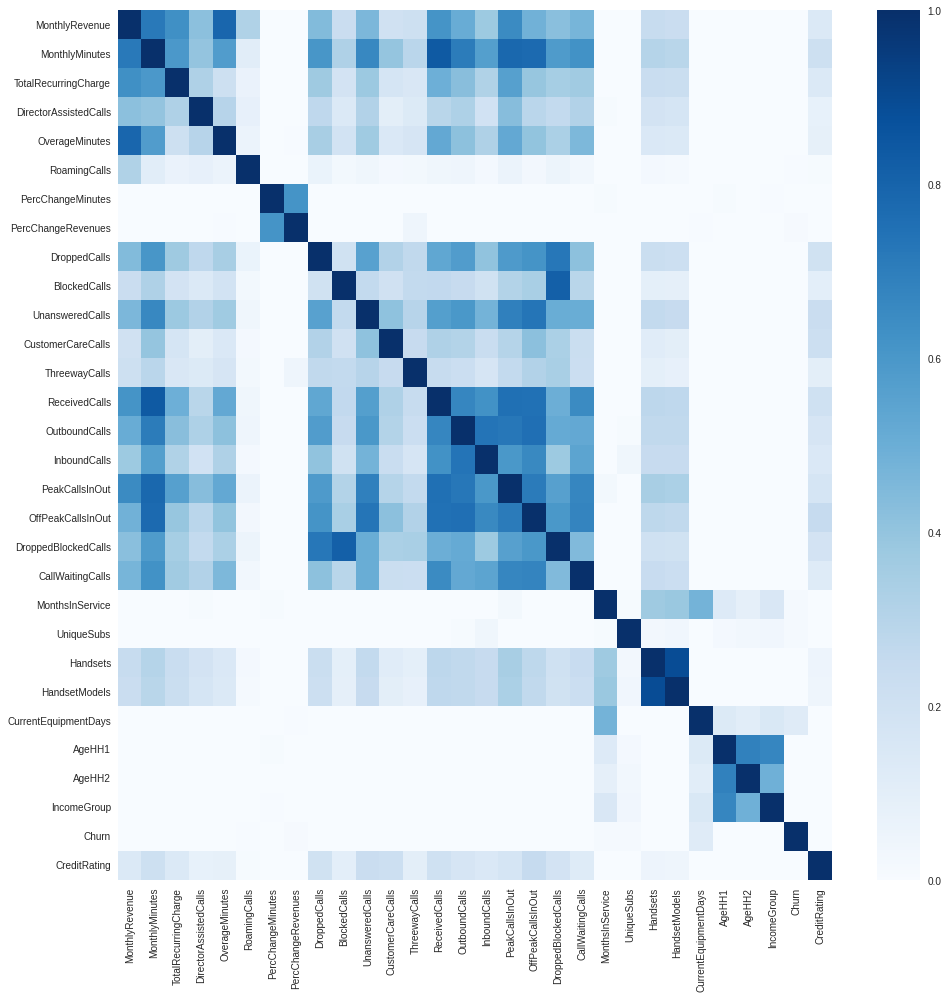

In [47]:
corr = data_reduced.corr()
plt.figure(figsize = (16, 16))
sns.heatmap(corr,vmin=0, vmax=1,cmap='Blues');

In [48]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tabla
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

table_corr = tidy_corr_matrix(corr)

In [49]:
table_corr_80 = table_corr[table_corr['abs_r'] > 0.8]
table_corr_80

,variable_1,variable_2,r,abs_r
683,Handsets,HandsetModels,0.892818,0.892818
712,HandsetModels,Handsets,0.892818,0.892818
43,MonthlyMinutes,ReceivedCalls,0.836306,0.836306
391,ReceivedCalls,MonthlyMinutes,0.836306,0.836306
549,DroppedBlockedCalls,BlockedCalls,0.814851,0.814851
288,BlockedCalls,DroppedBlockedCalls,0.814851,0.814851


In [50]:
#from google.colab import files
#data_reduced.to_csv('/content/drive/MyDrive/TFM/cell2cell.csv', index=False, header=True)

#files.download('cell2cell.csv')